In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import csv
import seaborn as sns
import tracemalloc

## **`Part 1`**: **`BUC Algorithm`**

In [23]:
df=pd.read_csv("./master.csv")
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($)
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


In [25]:
row,dim=df.shape
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

### *`Pre-Processing the data`*

In [26]:
def preprocess_population(df):
    df["population"].describe()
    pop_features = df["population"].describe()

    bins = [0, pop_features["25%"], pop_features["75%"], pop_features["max"]]
    label_names = ["low", "medium", "high"]
    df["population"] = pd.cut(df["population"], bins=bins, labels=label_names)
    return df

In [27]:
def preprocess_suicides_no(df):
    sui_data = df["suicides_no"].describe()
    bins = [i*50 for i in range(int(sui_data["75%"])//10 + 1)]
    bins[0]=-1
    bins.append(int(sui_data["max"])+1)
    labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
    labels[-1]=">{})".format(bins[-2])

    df["suicides_no"]=pd.cut(df["suicides_no"],bins=bins,labels=labels)
    return df

In [28]:
def preprocess_gdp_for_year(df):
    df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].apply(lambda x: float(x.replace(",","")))
    
    gdp_data=df[' gdp_for_year ($) '].describe()
    gdp_data
    bins = [0, gdp_data["25%"], gdp_data["75%"]]
    bins.append(gdp_data["max"]+1)
    labels=["Low", "Medium", "High"]
    df[" gdp_for_year ($) "]=pd.cut(df[" gdp_for_year ($) "],bins=bins,labels=labels)
    return df

In [29]:
def preprocess_gdp_per_capita(df):
    per_capita_data=df["gdp_per_capita ($)"].describe()
    bins=[i*1000 for i in range(int(per_capita_data["75%"])//1000)]
    bins.append(int(per_capita_data["max"]))
    labels=["{}-{}".format(bins[i],bins[i+1]) for i in range(len(bins)-1)]
    labels[-1]=">{}".format(bins[-2])

    df["gdp_per_capita ($)"].describe()
    df["gdp_per_capita ($)"]=pd.cut(df["gdp_per_capita ($)"],bins=bins,labels=labels)
    return df

In [30]:
def preprocess_data(df):

    df=preprocess_gdp_per_capita(preprocess_gdp_for_year(preprocess_suicides_no(preprocess_population(df))))

    df.drop(axis=1,columns=["suicides/100k pop","HDI for year","country-year"],inplace=True)
    return df

* The bins were decided manually for some and by nature of values

In [31]:
def aggregate(data):
    cur_col=data[:,0]
    unique,datacounts=np.unique(cur_col,return_counts=True)
    return unique,datacounts

### *`BUC Algorithm`*
* **Minimum support was kept in multiples of 250**

In [32]:
min_sup_list=[100,250,500,750,1000]

def compute_cube(data,output_rec):
    dim=data.shape[1]
    if(dim==0):
        all_cube.append(output_rec.copy())
        all_cube[-1].append(len(data))
        return
    


    idx=data[:,0].argsort()
    data=data[idx]

    unique_attr,datacount=aggregate(data)
    k=0
    cardinality=len(unique_attr)
    for i in range(cardinality):
        count=datacount[i]
        if(count>=min_sup):
            output_rec.append(data[k,0])
            compute_cube(data[k:k+count,1:],output_rec)
            output_rec.pop()
        k+=count
    output_rec.append("ALL")
    compute_cube(data[:,1:],output_rec)
    output_rec.pop()

run_time=[]
memory_allot=[]

df=preprocess_data(df)

for min_sup in min_sup_list:
    min_sup=min_sup
    output_rec=[]
    all_cube=[]
    data=df.values
    start=time.time()
    tracemalloc.start()

    compute_cube(data,output_rec)
    end=time.time()
    if(min_sup==100):
        result=pd.DataFrame(all_cube)
        cols_name=list(df.columns)
        cols_name.append('count')
        result.columns=cols_name
        result.to_csv('result.csv')
    memory_allot.append((tracemalloc.get_traced_memory()[1])/(1024*1024))
    tracemalloc.stop()
    run_time.append(end-start)

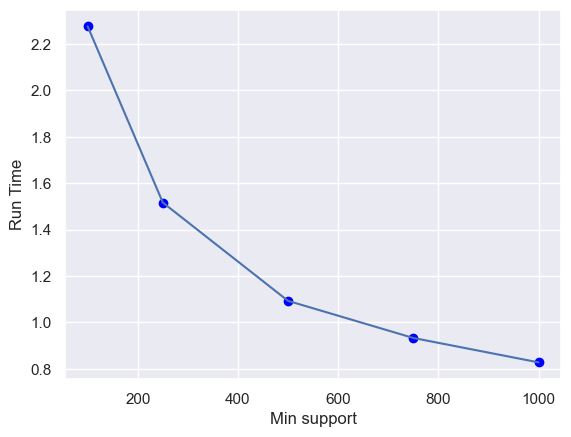

In [33]:
sns.set()
plt.figure()
plt.plot(min_sup_list,run_time)
plt.scatter(min_sup_list,run_time,marker='o',color='blue')
plt.xlabel("Min support")
plt.ylabel("Run Time")
plt.show()

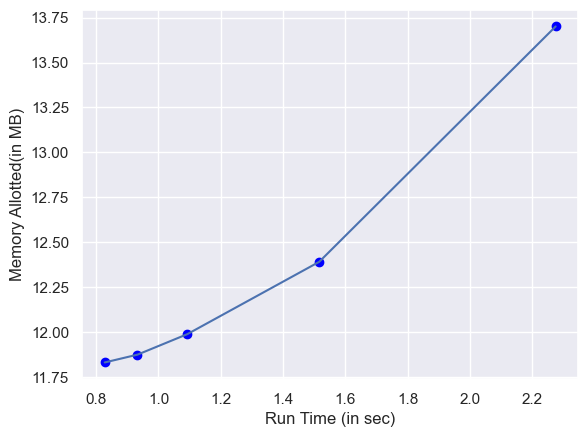

In [34]:
sns.set()
plt.figure()
plt.plot(run_time,memory_allot)
#  set sns marker = "."
plt.scatter(run_time,memory_allot,marker="o",color="Blue")
plt.ylabel("Memory Allotted(in MB)")
plt.xlabel("Run Time (in sec)")
plt.show()

## **`Part 2`**: **`BUC Algorithm (Memory Constraint)`**

In [35]:
def merge_files(filename,file_path1,file_path2,start,mid,end,columns,attr):
    size_1=mid-start+1
    size_2=end-mid

    p1=0
    p2=0
   
    with open(filename,"w") as file:
        writer=csv.writer(file)
        with open(file_path1) as file1, open(file_path2) as file2:
            r1=csv.reader(file1,delimiter=",")
            r2=csv.reader(file2,delimiter=",")
            next(r1)
            next(r2)
            val1=next(r1)
            val2=next(r2)
            writer.writerow(columns)
            while(p1<size_1 and p2<size_2):
                if(val1[attr]<=val2[attr]):
                    writer.writerow(val1)
                    p1+=1
                    if(p1>=size_1): break
                    val1=next(r1)
                else:
                    writer.writerow(val2)
                    p2+=1
                    if(p2>=size_2): break
                    val2=next(r2)
            while(p1<size_1):
                writer.writerow(val1)
                p1+=1
                if(p1>=size_1): break
                val1=next(r1)
            while(p2<size_2):
                writer.writerow(val2)
                p2+=1
                if(p2>=size_2): break
                val2=next(r2)

In [36]:
def external_merge_sort(filename,start,end,attr,columns,numRows):
    if(end-start<numRows):
        curr_df=pd.read_csv(filename)
        curr_df.sort_values(by=attr,inplace=True)
        curr_df.set_index(curr_df.columns[0],inplace=True)
        curr_df.to_csv(filename)
        return
    
    mid=(end+start)//2
    file1=[]
    file2=[]

    with open(filename,'r') as csv_file:
        reader=csv.reader(csv_file,delimiter=",")
        next(reader)
        for index,line in enumerate(reader):
            if(index<=mid-start):
                file1.append(line)
            else:
                file2.append(line)
    
    file_path="{}_{}_{}.csv"
    
    file_path1=file_path.format(start,mid,attr)
    file_path2=file_path.format(mid+1,end,attr)

    file1=pd.DataFrame(file1,columns=columns)
    file1.set_index(file1.columns[0],inplace=True)
    file1.to_csv(file_path1)
    external_merge_sort(file_path1,start,mid,attr,columns,numRows)

    file2=pd.DataFrame(file2,columns=columns)
    file2.set_index(file2.columns[0],inplace=True)
    file2.to_csv(file_path2)

    external_merge_sort(file_path2,mid+1,end,attr,columns,numRows)
    merge_files(filename,file_path1,file_path2,start,mid,end,columns,list(columns).index(attr))
    os.remove(file_path1)
    os.remove(file_path2)

In [37]:
def aggregate_page(filename,attr):
    dict={}
    with open(filename,"r") as file:
        reader =csv.reader(file)
        next(reader)
        for row in reader:
            if row[attr] in dict:
                dict[row[attr]]+=1
            else:
                dict[row[attr]]=1
    return list(dict.keys()),list(dict.values())

def aggregate(data):
    cur_col=data[:,0]
    unique,datacounts=np.unique(cur_col,return_counts=True)
    return unique,datacounts

In [38]:
block_size=2
page_dict={}
global pageNumber
pageNumber=0
class PageTable:
    def __init__(self,filename,pageSize):
        self.filename=filename
        row_num=0
        df_temp=pd.read_csv(filename,nrows=1)
        self.numCol=len(df_temp.columns)
        self.col=df_temp.columns

        with open(filename,"r") as file:
            reader=csv.reader(file)
            for row in reader:
                row_num+=1
        self.numRows=row_num
        self.pageSize=pageSize
        self.numRowsBlock=block_size*pageSize//self.numCol
    
    def partitionAttr(self,attr):  # partition on basis of attr
        external_merge_sort(self.filename,0,self.numRows-2,attr,self.col,self.numRowsBlock)
        global pageNumber
        unique_attr,datacount=aggregate_page(self.filename,list(self.col).index(attr))
        with open(self.filename,"r") as file:
            reader=csv.reader(file,delimiter=",")
            next(reader)
            for i in range(len(unique_attr)):
                count=datacount[i]
                with open("page_{}".format(pageNumber),"w") as file:
                    writer=csv.writer(file)
                    page_dict["{}_{}_{}".format(self.filename,attr,i)]="page_{}".format(pageNumber)
                    index=list(self.col).index(attr)
                    writer.writerow(list(self.col)[index:])
                    pageNumber+=1
                    for row in reader:
                        writer.writerow(row[index:])
                        count-=1
                        if(count==0): break
        return unique_attr,datacount
        

In [39]:
all_cube=[]
mins_up=100
def compute(table,curr_rec,attr,subset):
    
    if(attr==None):
        all_cube.append(curr_rec.copy())
        if(len(subset)==0):
            all_cube[-1].append(table.numRows-1)
        else:
            all_cube[-1].append(len(subset))
        return

    if(len(subset)==0):
        if(table.numRows-1>table.numRowsBlock):
            unique_attr,datacount=table.partitionAttr(attr)
        else:
            subset=(pd.read_csv(table.filename)).values
            index=list(table.col).index(attr)
            subset=subset[:,index:]
            idx=subset[:,0].argsort()
            subset=subset[idx]
            unique_attr,datacount=aggregate(subset)
    else:
        idx=subset[:,0].argsort()
        subset=subset[idx]
        unique_attr,datacount=aggregate(subset)
    
    k=0
    for i in range(len(unique_attr)):
        count=datacount[i]
        if(len(subset)==0):
            if(count>=mins_up):
                tab=PageTable(page_dict["{}_{}_{}".format(table.filename,attr,i)],table.pageSize)
                curr_rec.append(unique_attr[i])
                index=list(table.col).index(attr)
                if(table.numCol>index+1):
                    compute(tab,curr_rec,list(table.col)[index+1],[])
                else:
                    compute(tab,curr_rec,None,[])
                curr_rec.pop()
        else:
            if(count>=mins_up):
                curr_rec.append(subset[k,0])
                if(subset.shape[1]>1):
                    compute(table,curr_rec,attr,subset[k:k+count,1:])
                else:
                    compute(table,curr_rec,None,subset[k:k+count,1:])
                curr_rec.pop()
        k+=count
    
    curr_rec.append("ALL")
    index=list(table.col).index(attr)
    if(len(subset)==0):
        if(table.numCol>index+1):
            compute(table,curr_rec,list(table.col)[index+1],[])
        else:
            compute(table,curr_rec,None,[])
    else:
        if(subset.shape[1]>1):
            compute(table,curr_rec,attr,subset[:,1:])
        else:
            compute(table,curr_rec,None,subset[:,1:])
    curr_rec.pop()

In [40]:
df=pd.read_csv("./master.csv")
df=preprocess_data(df)
df.set_index(list(df.columns)[0],inplace=True)
df.to_csv("masterCleaned.csv")

In [41]:
page_size=[1000,2000,5000,10000]
time_taken=[]
for i in page_size:
    table=PageTable("masterCleaned.csv",i)
    page_dict={}
    global pageNumber
    pageNumber=0
    curr_rec=[]
    subset=[]
    all_cube=[]
    start=time.time()
    compute(table,curr_rec,list(table.col)[0],subset)
    end=time.time()
    time_taken.append(end-start)
    result=pd.DataFrame(all_cube)
    result.to_csv("result_{}.csv".format(i))

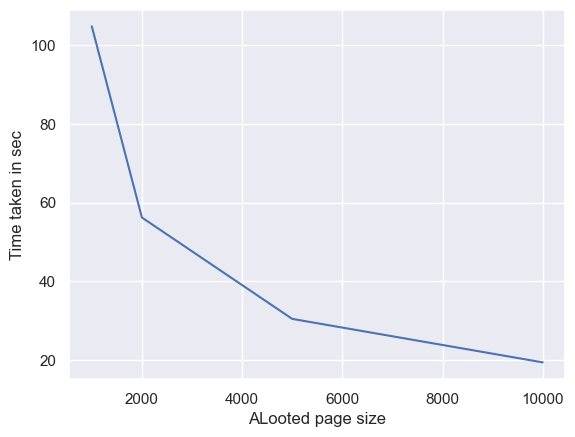

In [42]:
plt.figure()
plt.plot(page_size,time_taken)
plt.xlabel("ALooted page size")
plt.ylabel("Time taken in sec")
plt.show()

## **`Part 3`**: **`AOI Algorithm`**

In [45]:
df = pd.read_excel('cleaned_data.xlsx')

In [46]:
df.columns

Index(['Property_Name', 'Property_id', 'Property_type', 'Property_status',
       'Price_per_unit_area', 'Posted_On', 'Project_URL', 'builder_id',
       'Builder_name', 'Property_building_status', 'City_id', 'City_name',
       'No_of_BHK', 'Locality_ID', 'Locality_Name', 'Longitude', 'Latitude',
       'Price', 'Size', 'Sub_urban_ID', 'Sub_urban_name', 'description',
       'is_furnished', 'listing_domain_score', 'is_plot', 'is_RERA_registered',
       'is_Apartment', 'is_ready_to_move', 'is_commercial_Listing',
       'is_PentaHouse', 'is_studio', 'Listing_Category'],
      dtype='object')

***
## `Preprocessing`

In [47]:
df['Price_per_unit_area'] = df['Price_per_unit_area'].apply(lambda x : float(str(x).replace(",","")))
df['Size'] = df['Size'].apply(lambda x: int(x[:-6].replace(",","")) )
df['Price'] = df['Price'].apply(lambda x: float(x.replace(",","")))

In [48]:
budget_ranges = [
    {"label": "Low Budget", "min": 0, "max": 10000},
    {"label": "Medium Budget", "min": 10001, "max": 30000},
    {"label": "High Budget", "min": 30001, "max": float("inf")}
]

budget_by_price = [
    {"label": "Low Budget", "min": 1, "max": 10000000},
    {"label": "Medium Budget", "min": 10000001, "max": 30000000},
    {"label": "High Budget", "min": 30000001, "max": float("inf")}
]

def categorize_budget(row):
    for budget_range in budget_ranges:
        if budget_range["min"] <= row["Price_per_unit_area"] <= budget_range["max"]:
            return budget_range["label"]
        
def categorize_budget_by_price(row):
    for budget_range in budget_by_price:
        if budget_range["min"] <= row["Price"] <= budget_range["max"]:
            return budget_range["label"]

df["Price"] = df.apply(categorize_budget_by_price, axis=1)
df["Price_per_unit_area"] = df.apply(categorize_budget, axis=1)

In [49]:

# parses dates correctly
def calc(x):
    if("day" in x):
        p= (x.split(" ")[0])
        if("a" in p):
            return 1.0
        return float(p)
    elif("month" in x):
        p= (x.split(" ")[0])
        if("a" in p):
            return 30.0
        return float(p)*30    
    elif("hour" in x):
        p= (x.split(" ")[0])
        if("a" in p):
            return 1.0/24
        return float(p)/24

    elif("minute" in x):
        p= (x.split(" ")[0])
        if("a" in p):
            return 1.0/(24*60)
        return float(p)/(24*60)
    elif("year" in x):
        p= (x.split(" ")[0])
        if("a" in p):
            return 365.0
        return float(p)*365

# print(df["Posted_On"].info())
df["Posted_On"]=df["Posted_On"].apply(lambda x: calc(x))

***
## `Extracting data by creating bins , `
### `pruning columns with excess values`

In [50]:
size_data= df["Size"].describe()
bins=[-1,1.5e3,3e3,4.5e3,6e3,7.5e3]
bins.append(size_data["max"])
labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
labels[-1]=">7500"
bins
df["Size"]=pd.cut(df["Size"],bins=bins,labels=labels)

In [51]:
domain_score= df["listing_domain_score"].describe()
bins=[-1,4,5,6,7,8,9]
labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
labels[-1]=">9"
df["listing_domain_score"]=pd.cut(df["listing_domain_score"],bins=bins,labels=labels)

In [52]:
len(df["Property_Name"].unique())

20509

- **Because of a large set of unique values, we drop the following column** 

In [53]:
df.drop(axis=1, columns=["Property_Name"],inplace=True)

In [54]:
len(df["Property_id"].unique())

100691

* **Higher unique values**

In [55]:
df.drop(axis=1, columns=["Property_id"],inplace=True)

In [56]:
len(df["Property_type"].unique())

5

- **Because of a few, but informative values, we keep the following column**

In [57]:
len(df["Property_status"].unique())

2

In [58]:
# df[df["Posted_On"].isna()]
date_posted= df["Posted_On"].describe()
bins=[-1,10,20,30,40,50]
bins.append(date_posted["max"])
labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
labels[-1]=">50"
df["Posted_On"]=pd.cut(df["Posted_On"],bins=bins,labels=labels)

- **Because of a large set of unique values, we drop the following column** 

In [59]:
print(len(df["Project_URL"].unique()))
df.drop(axis=1, columns=["Project_URL"],inplace=True)

20674


- **Because of a large set of unique values, we drop the following column** 

In [60]:
print(len(df["builder_id"].unique()))
df.drop(axis=1, columns=["builder_id"],inplace=True)

8350


- **Because of a large set of unique values, we drop the following column** 

In [61]:
print(len(df["Builder_name"].unique()))
df.drop(axis=1, columns=["Builder_name"],inplace=True)

8347


In [62]:
len(df["Property_building_status"].unique())

3

- **Because of a large set of unique values, we drop the following column** 

In [63]:
df.drop(axis=1, columns=["City_id"],inplace=True)

len(df["City_name"].unique())

In [64]:
df["No_of_BHK"]= df["No_of_BHK"].apply(lambda x: int(x.split(" ")[0]))
bins=[-1,3,6,9,12]
bins.append(df["No_of_BHK"].max())
# bins
labels=["{}-{}".format(bins[i]+1,bins[i+1]) for i in range(len(bins)-1)]
labels[-1]=">16"
df["No_of_BHK"]=pd.cut(df["No_of_BHK"],bins=bins,labels=labels)

In [65]:
df.drop(axis=1, columns=["Locality_ID", "Longitude","Latitude", "Sub_urban_ID"],inplace=True)

### Merging, suburban names, to city names, by creating a dictionary for each city.

In [66]:
df["Sub_urban_name"].unique()
city_to_suburban= {}
def remove_other_from_suburban_name(x):
    if "Other" in x["Sub_urban_name"]:
        x["Sub_urban_name"]=x["City_name"]+ " other"
        # print(x["Sub_urban_name"])
    return x
df=df.apply(remove_other_from_suburban_name,axis=1)
for city in df["City_name"].unique():
    city_to_suburban[city]= list(df[df["City_name"]==city]["Sub_urban_name"].unique())
# df

In [67]:
def change_urban_name(x):
    for city in city_to_suburban:
        if x in city_to_suburban[city]:
            return city
    return x

df["Sub_urban_name"]=df["Sub_urban_name"].apply(lambda x: change_urban_name(x))

In [68]:
# do the same mapping for locality name
city_to_locality= {}

for city in df["City_name"].unique():
    city_to_locality[city]= list(df[df["City_name"]==city]["Locality_Name"].unique())


In [69]:
def change_locality_name(x):
    for city in city_to_locality:
        if x in city_to_locality[city]:
            return city
    return x
df["Locality_Name"]=df["Locality_Name"].apply(lambda x: change_locality_name(x))

In [70]:
df.drop(axis=1, columns=["description"],inplace=True)

In [71]:
df.columns

Index(['Property_type', 'Property_status', 'Price_per_unit_area', 'Posted_On',
       'Property_building_status', 'City_name', 'No_of_BHK', 'Locality_Name',
       'Price', 'Size', 'Sub_urban_name', 'is_furnished',
       'listing_domain_score', 'is_plot', 'is_RERA_registered', 'is_Apartment',
       'is_ready_to_move', 'is_commercial_Listing', 'is_PentaHouse',
       'is_studio', 'Listing_Category'],
      dtype='object')

In [72]:
df.drop(axis=1, columns=['is_furnished', 'is_plot', 'is_RERA_registered', 'is_Apartment',
       'is_ready_to_move', 'is_commercial_Listing', 'is_PentaHouse',
       'is_studio'],inplace=True)

In [73]:
# grouping by all columns
df=df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

In [74]:
df.to_excel("aoi.xlsx",index=False)

### `By now aggregating the data, we get the following columns with their respective counts.`
#### And as we can see, the total count now equals the initial number of rows

In [75]:
df

,Property_type,Property_status,Price_per_unit_area,Posted_On,Property_building_status,City_name,No_of_BHK,Locality_Name,Price,Size,Sub_urban_name,listing_domain_score,Listing_Category,count
0,Apartment,Ready to move,High Budget,0-10,ACTIVE,Bangalore,4-6,Bangalore,High Budget,3001.0-4500.0,Bangalore,0-4,sell,1
1,Apartment,Ready to move,High Budget,0-10,ACTIVE,Bangalore,4-6,Bangalore,High Budget,>7500,Bangalore,0-4,sell,1
2,Apartment,Ready to move,High Budget,0-10,ACTIVE,Delhi,0-3,Delhi,High Budget,1501.0-3000.0,Delhi,0-4,sell,1
3,Apartment,Ready to move,High Budget,0-10,ACTIVE,Delhi,4-6,Delhi,High Budget,3001.0-4500.0,Delhi,0-4,sell,1
4,Apartment,Ready to move,High Budget,0-10,ACTIVE,Mumbai,0-3,Mumbai,High Budget,0-1500.0,Mumbai,0-4,sell,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2855,Villa,Under Construction,Medium Budget,>50,ACTIVE,Hyderabad,4-6,Hyderabad,High Budget,6001.0-7500.0,Hyderabad,0-4,sell,1
2856,Villa,Under Construction,Medium Budget,>50,ACTIVE,Lucknow,4-6,Lucknow,Medium Budget,1501.0-3000.0,Lucknow,0-4,sell,1
2857,Villa,Under Construction,Medium Budget,>50,ACTIVE,Mumbai,0-3,Mumbai,High Budget,3001.0-4500.0,Mumbai,0-4,sell,2
2858,Villa,Under Construction,Medium Budget,>50,ACTIVE,Mumbai,0-3,Mumbai,Medium Budget,1501.0-3000.0,Mumbai,0-4,sell,2
